<a href="https://colab.research.google.com/github/GoetheUniCV/cvproject/blob/main/models/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model



#Grad-CAM for COVID-19

##1. Setup
###1.1 Python Environment
Almost all required packages are preinstalled, except _kerastuner_. You can install it with `!pip install -U keras-tuner`.

###1.2 Google Drive
####1.2.1 Structure
Create the following directory structure in your Drive:
```
MyDrive
└── cvproject
    ├── COVID-10 Radiography Database
    │   ├── COVID-19
    │   ├── NORMAL
    │   └── Viral Pneumonia
    └── models
```
####1.2.2 Upload COVID-19 Dataset
The directory _COVID-10 Radiography Database_ must contain the dataset from Kaggle (https://www.kaggle.com/tawsifurrahman/covid19-radiography-database).

___


In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 4.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=61dcf9cb25ae761831a7ca83abb39c6b4da6ad4403bd0fca1e410a392a42bb51
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=0099396b9a34f3d489cb5795b4f6c7f5d2cb73a643dbc35baa6677d43d55a56b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras.preprocessing import image
from google.colab import drive

In [ ]:
# This mounts your Google Drive to the Colab VM.
drive.mount('/content/drive', force_remount=True)

# Foldername in your Drive where you have saved the COVID-19 data.
PROJECT_PATH = '/content/drive/My Drive/cvproject/'
DATABASE_PATH = f'{PROJECT_PATH}/COVID-19 Radiography Database'
MODELS_PATH = f'{PROJECT_PATH}/models'

#assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
#sys.path.append(FOLDERPATH)

Mounted at /content/drive


In [ ]:
# Check if database is complete.
try:
  if len(os.listdir(f'{DATABASE_PATH}/COVID-19')) == 1143:
    print('COVID-19 compelte.')
  else:
    print('COVID-19 incompelte.')

  if len(os.listdir(f'{DATABASE_PATH}/NORMAL')) == 1341:
    print('NORMAL compelte.')
  else:
    print('NORMAL incompelte.')

  if len(os.listdir(f'{DATABASE_PATH}/Viral Pneumonia')) == 1345:
    print('Viral Pneumonia compelte.')
  else:
    print('Viral Pneumonia incompelte.')
except FileNotFoundError:
  print("Warning: Some directories are missing!")



COVID-19 compelte.
NORMAL compelte.
Viral Pneumonia compelte.


In [ ]:
# Show label name and its encoded value:
class_names =  ["COVID-19","NORMAL","Viral Pneumonia"]

for i, class_name in enumerate(class_names):
    print(f'{class_name}: {i}')

COVID-19: 0
NORMAL: 1
Viral Pneumonia: 2


In [ ]:
# NOTE: Bildgröße aller Bilder wird auf 244 x 244 geändert. Leider sind die
#       Covid Bilder sehr klein. Normale und Lungenentzündung sind 1024 x 1024.

# NOTE: '= defect_tree =' entfernt

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 3829 files belonging to 3 classes.
Using 3064 files for training.
Found 3829 files belonging to 3 classes.
Using 765 files for validation.


In [ ]:
# Defining the CNN.
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.15),
  layers.Dense(3, activation= 'softmax')
])

In [ ]:
# Avoid overfitting...
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
# Compile the model.
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model.
history=model.fit(train_data,validation_data= test_data,batch_size=32,epochs = 20,callbacks=[early])

Epoch 1/20
96/96 [==============================] - 1462s 14s/step - loss: 1.5161 - accuracy: 0.7268 - val_loss: 0.7381 - val_accuracy: 0.8000
Epoch 2/20
96/96 [==============================] - 411s 4s/step - loss: 0.1752 - accuracy: 0.9413 - val_loss: 0.2363 - val_accuracy: 0.9190
Epoch 3/20
96/96 [==============================] - 420s 4s/step - loss: 0.1208 - accuracy: 0.9563 - val_loss: 0.1855 - val_accuracy: 0.9373
Epoch 4/20
96/96 [==============================] - 412s 4s/step - loss: 0.0913 - accuracy: 0.9704 - val_loss: 0.1744 - val_accuracy: 0.9346
Epoch 5/20
96/96 [==============================] - 416s 4s/step - loss: 0.0628 - accuracy: 0.9764 - val_loss: 0.1802 - val_accuracy: 0.9399
Epoch 6/20
96/96 [==============================] - 414s 4s/step - loss: 0.0633 - accuracy: 0.9765 - val_loss: 0.1503 - val_accuracy: 0.9490
Epoch 7/20
96/96 [==============================] - 415s 4s/step - loss: 0.0341 - accuracy: 0.9870 - val_loss: 0.1726 - val_accuracy: 0.9529
Epoch 8/20


In [ ]:
# Evaluate the model.
model.evaluate(test_data)

24/24 [==============================] - 32s 1s/step - loss: 0.2310 - accuracy: 0.9464


[0.23096494376659393, 0.9464052319526672]

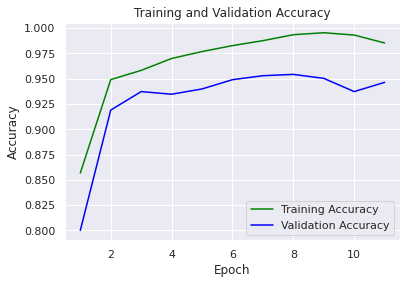

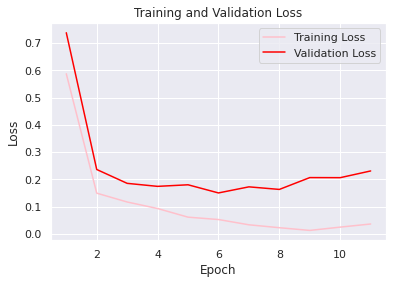

In [ ]:
#plotting training values
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

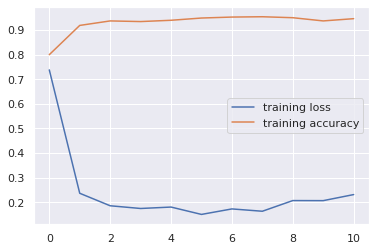

In [ ]:
#train data accuracy and loss
plt.plot(history.history['val_loss'], label = 'training loss')
plt.plot(history.history['val_accuracy'], label = 'training accuracy')
plt.legend()

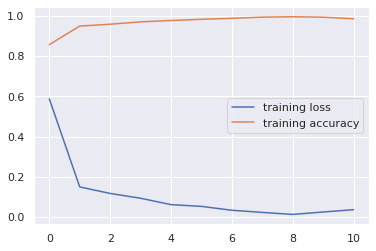

In [ ]:
#test data accuracy and loss
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.legend()

In [ ]:
#save file as h5 model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5

model.save(f'{MODELS_PATH}/model_2020-12-28.h5')

In [ ]:
model = keras.models.load_model(f'{MODELS_PATH}/model_2020-12-28.h5')

In [ ]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 244, 244, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 128)       7